# Problem Statement 1:
A cloth manufacturing company is interested to know about the segment or attributes causes high sale. 

Approach - A Random Forest can be built with target variable Sales (we will first convert it in categorical variable)
& all other variable will be independent in the analysis.  


## About the data: 
Let’s consider a Company dataset with around 10 variables and 400 records. 

The attributes are as follows: 

- Sales -- Unit sales (in thousands) at each location
- Competitor Price -- Price charged by competitor at each location
- Income -- Community income level (in thousands of dollars)
- Advertising -- Local advertising budget for company at each location (in thousands of dollars)
- Population -- Population size in region (in thousands)
- Price -- Price company charges for car seats at each site
- Shelf Location at stores -- A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
- Age -- Average age of the local population
- Education -- Education level at each location
- Urban -- A factor with levels No and Yes to indicate whether the store is in an urban or rural location
- US -- A factor with levels No and Yes to indicate whether the store is in the US or not

#### Importing Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from collections import Counter
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV

from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

import warnings
warnings.filterwarnings('ignore')

#### Loading Dataset

In [4]:
company_data = pd.read_csv('Company_Data.csv')
company_data

Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0     9.50        138      73           11         276    120       Bad   42   
1    11.22        111      48           16         260     83      Good   65   
2    10.06        113      35           10         269     80    Medium   59   
3     7.40        117     100            4         466     97    Medium   55   
4     4.15        141      64            3         340    128       Bad   38   
..     ...        ...     ...          ...         ...    ...       ...  ...   
395  12.57        138     108           17         203    128      Good   33   
396   6.14        139      23            3          37    120    Medium   55   
397   7.41        162      26           12         368    159    Medium   40   
398   5.94        100      79            7         284     95       Bad   50   
399   9.71        134      37            0          27    120      Good   49   

     Education Urban   US  
0           17   Yes  Yes  
1           10   Yes  Yes  
2           12   Yes  Yes  
3           14   Yes  Yes  
4           13   Yes   No  
..         ...   ...  ...  
395         14   Yes  Yes  
396         11    No  Yes  
397         18   Yes  Yes  
398         12   Yes  Yes  
399         16   Yes  Yes  

[400 rows x 11 columns]

#### EDA

In [5]:
company_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


In [6]:
company_data.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [7]:
company_data.dtypes

Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object

In [8]:
company_data.isna().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

In [9]:
company_data.shape

(400, 11)

In [10]:
company_data.duplicated().sum()

0

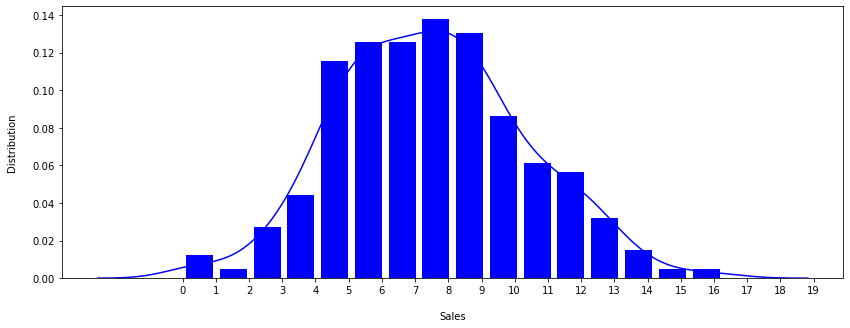

In [11]:
def distplot(param):
    plt.figure(figsize=(14,5))
    sns.distplot(company_data[param], color = "blue", hist_kws={"rwidth":0.80, 'alpha':1.0})
    plt.xticks(np.arange(0,20,1))
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
distplot("Sales")

As the Sales distribution is not skewed and it is normal distribution we can take mean or median as a threshold to make two or three categories 'Low', 'Medium' and 'High' Sales

For two categories lets assume: Sales < 7.5 as “Bad=0” and Sales > 7.5 as “Good=1”

For three categories lets divide the Sales values with Quartiles , less than first quartile as 'Low' , between Second Quartile as 'Medium and above Third Quartile as 'High'

In [12]:
company_data.Sales.describe()

count    400.000000
mean       7.496325
std        2.824115
min        0.000000
25%        5.390000
50%        7.490000
75%        9.320000
max       16.270000
Name: Sales, dtype: float64

In [13]:
company_data1 = company_data.copy()
company_data1['SalesCat'] = pd.cut(x = company_data1['Sales'], bins = [0,5.39,9.32,17], labels=['Low','Medium','High'], right = False)
company_data1.head()

Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US SalesCat  
0         17   Yes  Yes     High  
1         10   Yes  Yes     High  
2         12   Yes  Yes     High  
3         14   Yes  Yes   Medium  
4         13   Yes   No      Low

In [14]:
company_data1.SalesCat.value_counts()

Medium    198
High      102
Low       100
Name: SalesCat, dtype: int64

In [15]:
company_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    object  
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    object  
 10  US           400 non-null    object  
 11  SalesCat     400 non-null    category
dtypes: category(1), float64(1), int64(7), object(3)
memory usage: 35.0+ KB


In [16]:
categorical_features = company_data1.describe(include=["object",'category']).columns
categorical_features

Index(['ShelveLoc', 'Urban', 'US', 'SalesCat'], dtype='object')

In [17]:
numerical_features = company_data1.describe(include=["int64","float64"]).columns
numerical_features

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'Age', 'Education'],
      dtype='object')

#### Univariate plots

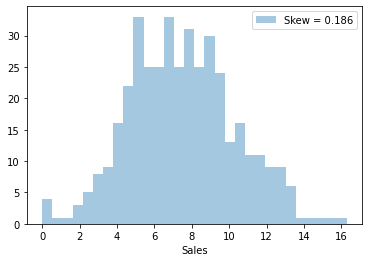

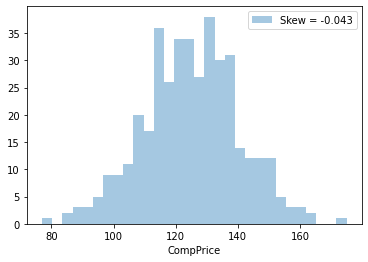

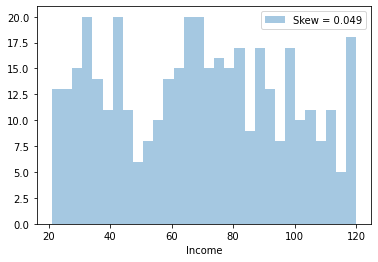

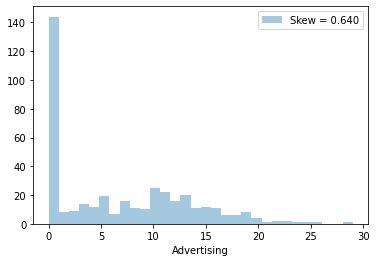

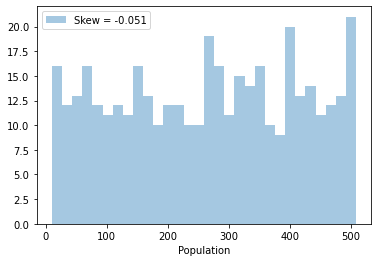

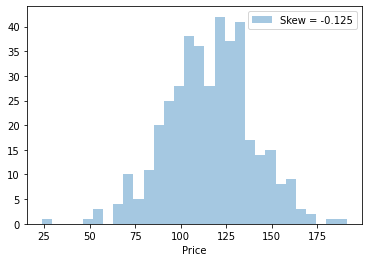

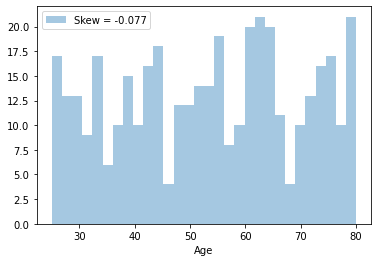

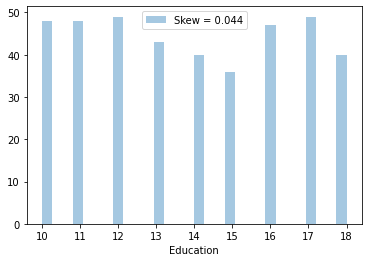

In [18]:
numerical_features = [feature for feature in company_data.columns if company_data[feature].dtypes != 'O']
for feat in numerical_features:
    skew = company_data[feat].skew()
    sns.distplot(company_data[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

#### Observation
- None of the features is normally distributed.

#### Outliers

In [19]:
numerical_features

['Sales',
 'CompPrice',
 'Income',
 'Advertising',
 'Population',
 'Price',
 'Age',
 'Education']

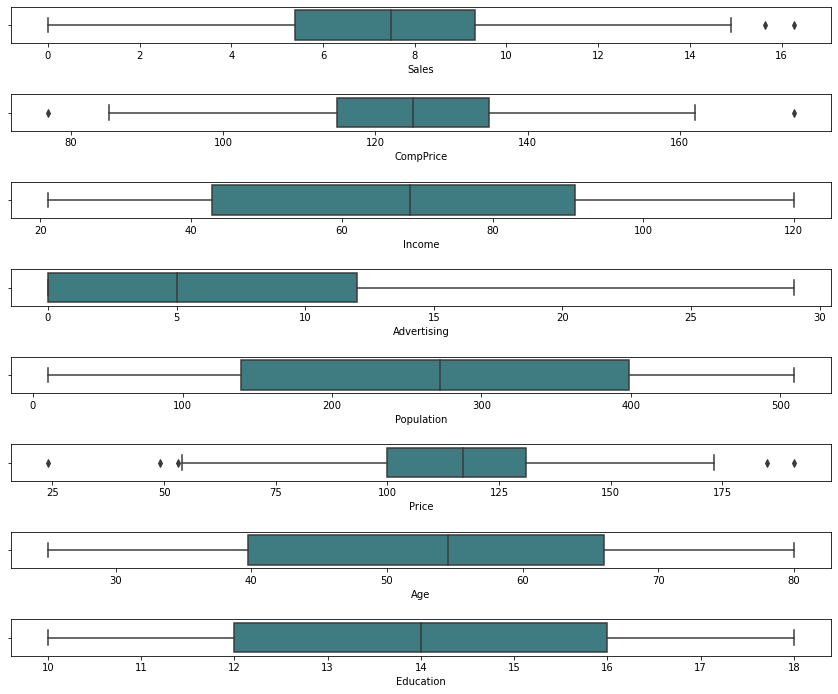

In [20]:
outliers = company_data.copy() 
fig, axes = plt.subplots(8,1,figsize=(12,10),sharex=False,sharey=False)
sns.boxplot(x='Sales', data= outliers,palette='crest',ax=axes[0])
sns.boxplot(x='CompPrice',data= outliers,palette='crest',ax=axes[1])
sns.boxplot(x='Income',data= outliers,palette='crest',ax=axes[2])
sns.boxplot(x='Advertising',data= outliers,palette='crest',ax=axes[3])
sns.boxplot(x='Population',data= outliers,palette='crest',ax=axes[4])
sns.boxplot(x='Price',data= outliers,palette='crest',ax=axes[5])
sns.boxplot(x='Age',data= outliers,palette='crest',ax=axes[6])
sns.boxplot(x='Education',data= outliers,palette='crest',ax=axes[7])
plt.tight_layout(pad=2.0)

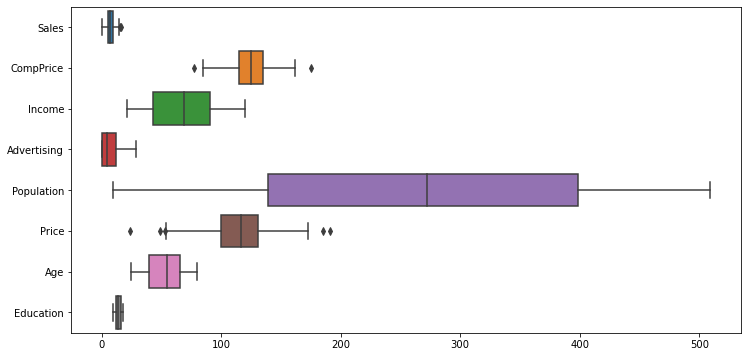

In [21]:
plt.figure(figsize=(12,6))
sns.boxplot(data=company_data[numerical_features], orient="h")
plt.show()

#### Observation:
- Mean of population is higher

#### Multivariate Analysis

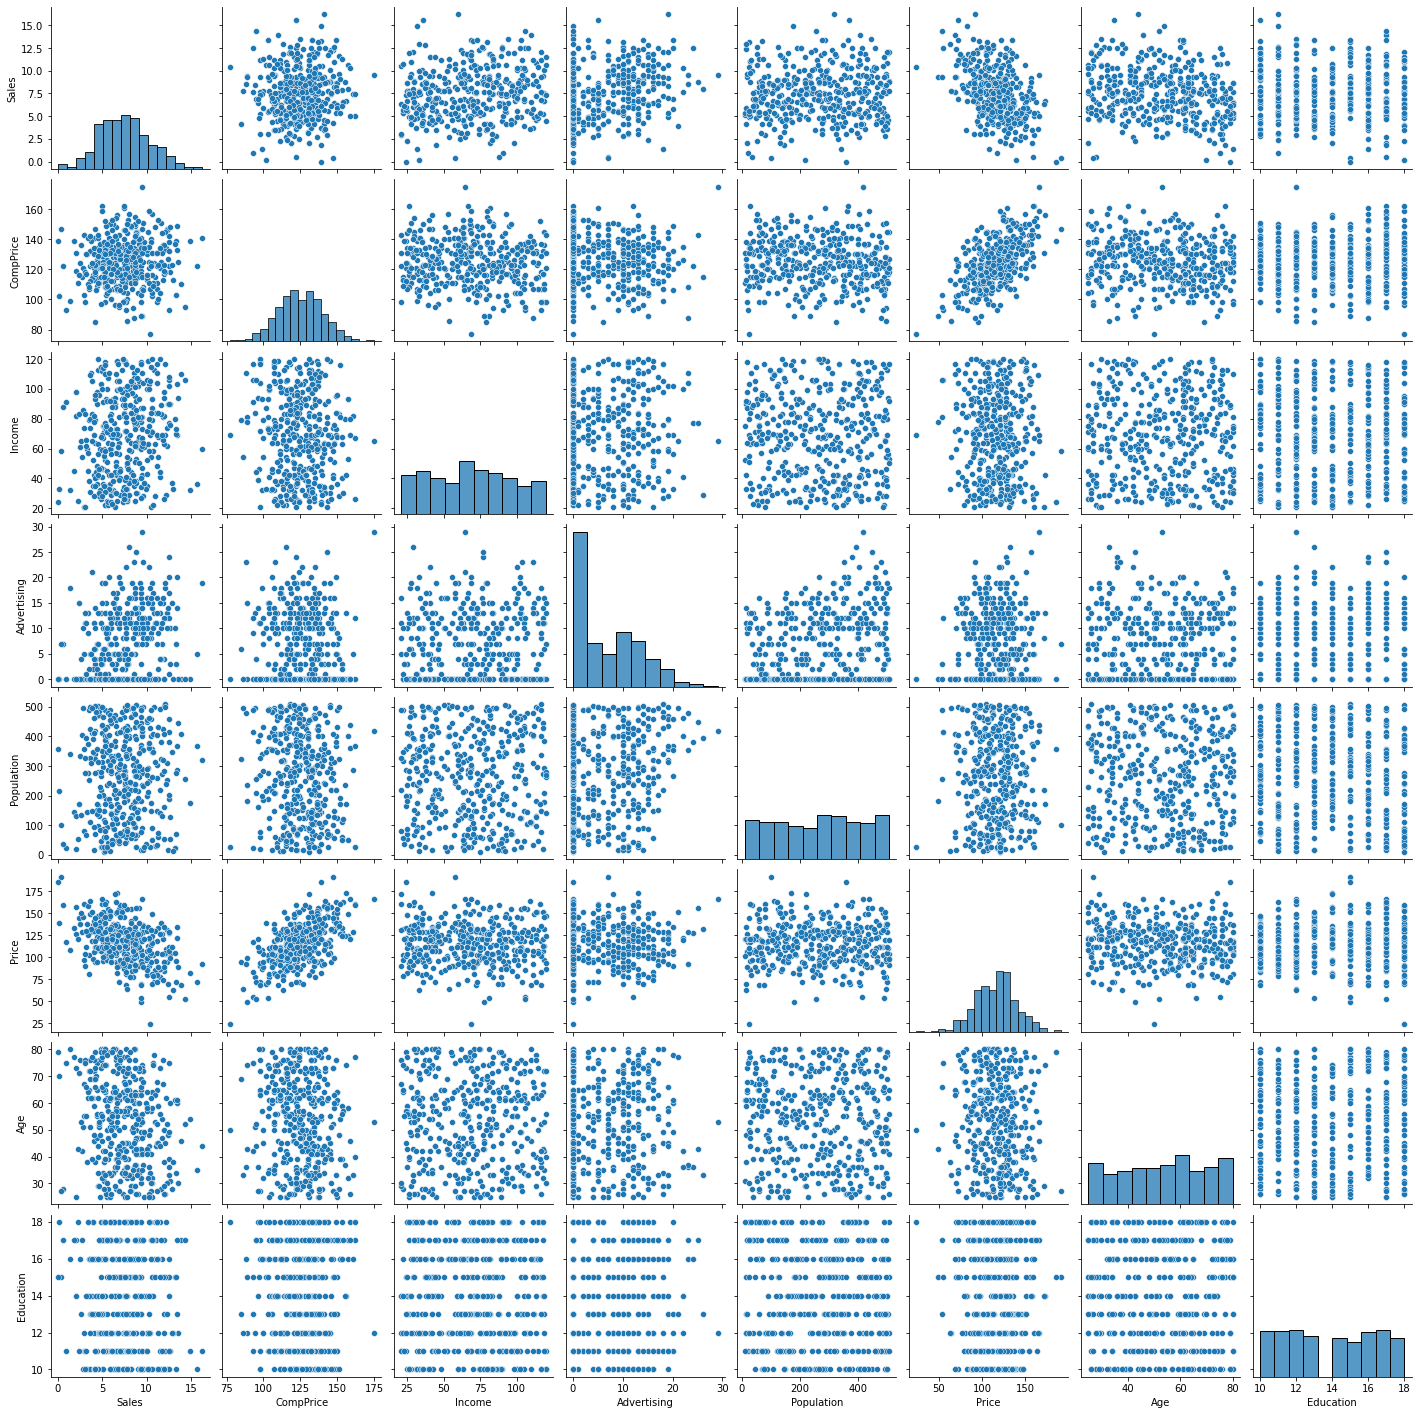

In [22]:
sns.pairplot(company_data, palette='coolwarm')
plt.show()

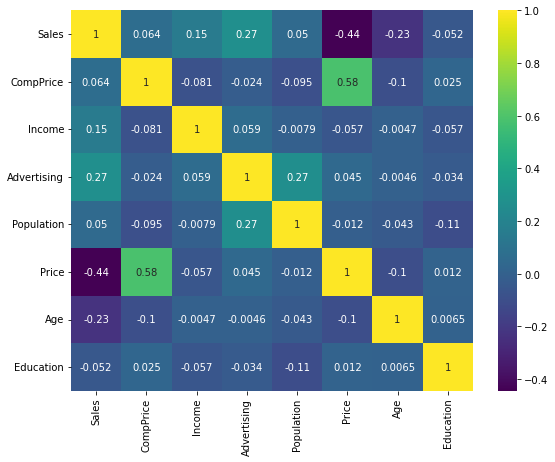

In [23]:
#correlation matrix
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(company_data.corr(), annot=True, fmt='.2g', cmap="viridis")
plt.show()

Index(['ShelveLoc', 'Urban', 'US', 'SalesCat'], dtype='object')


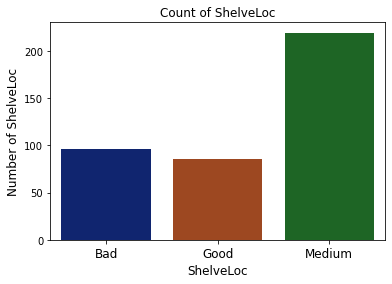

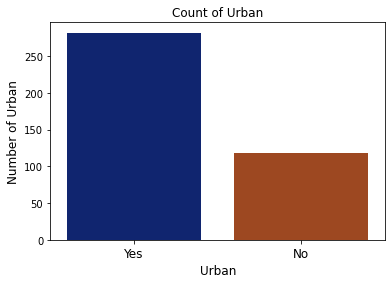

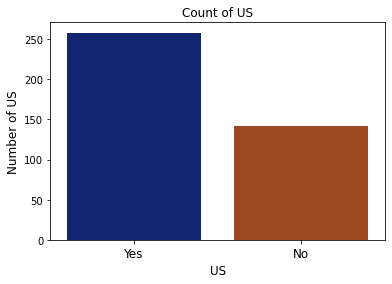

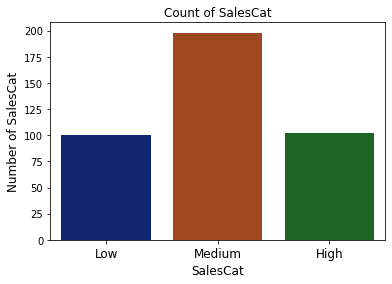

In [24]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(6,4))
    unique = company_data1[column].value_counts(ascending=True);   
    plt.title("Count of "+ column)
    sns.countplot(data= company_data1, x=column, palette = "dark")
    plt.xticks(rotation = 0, size = 12)
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)
plt.show()

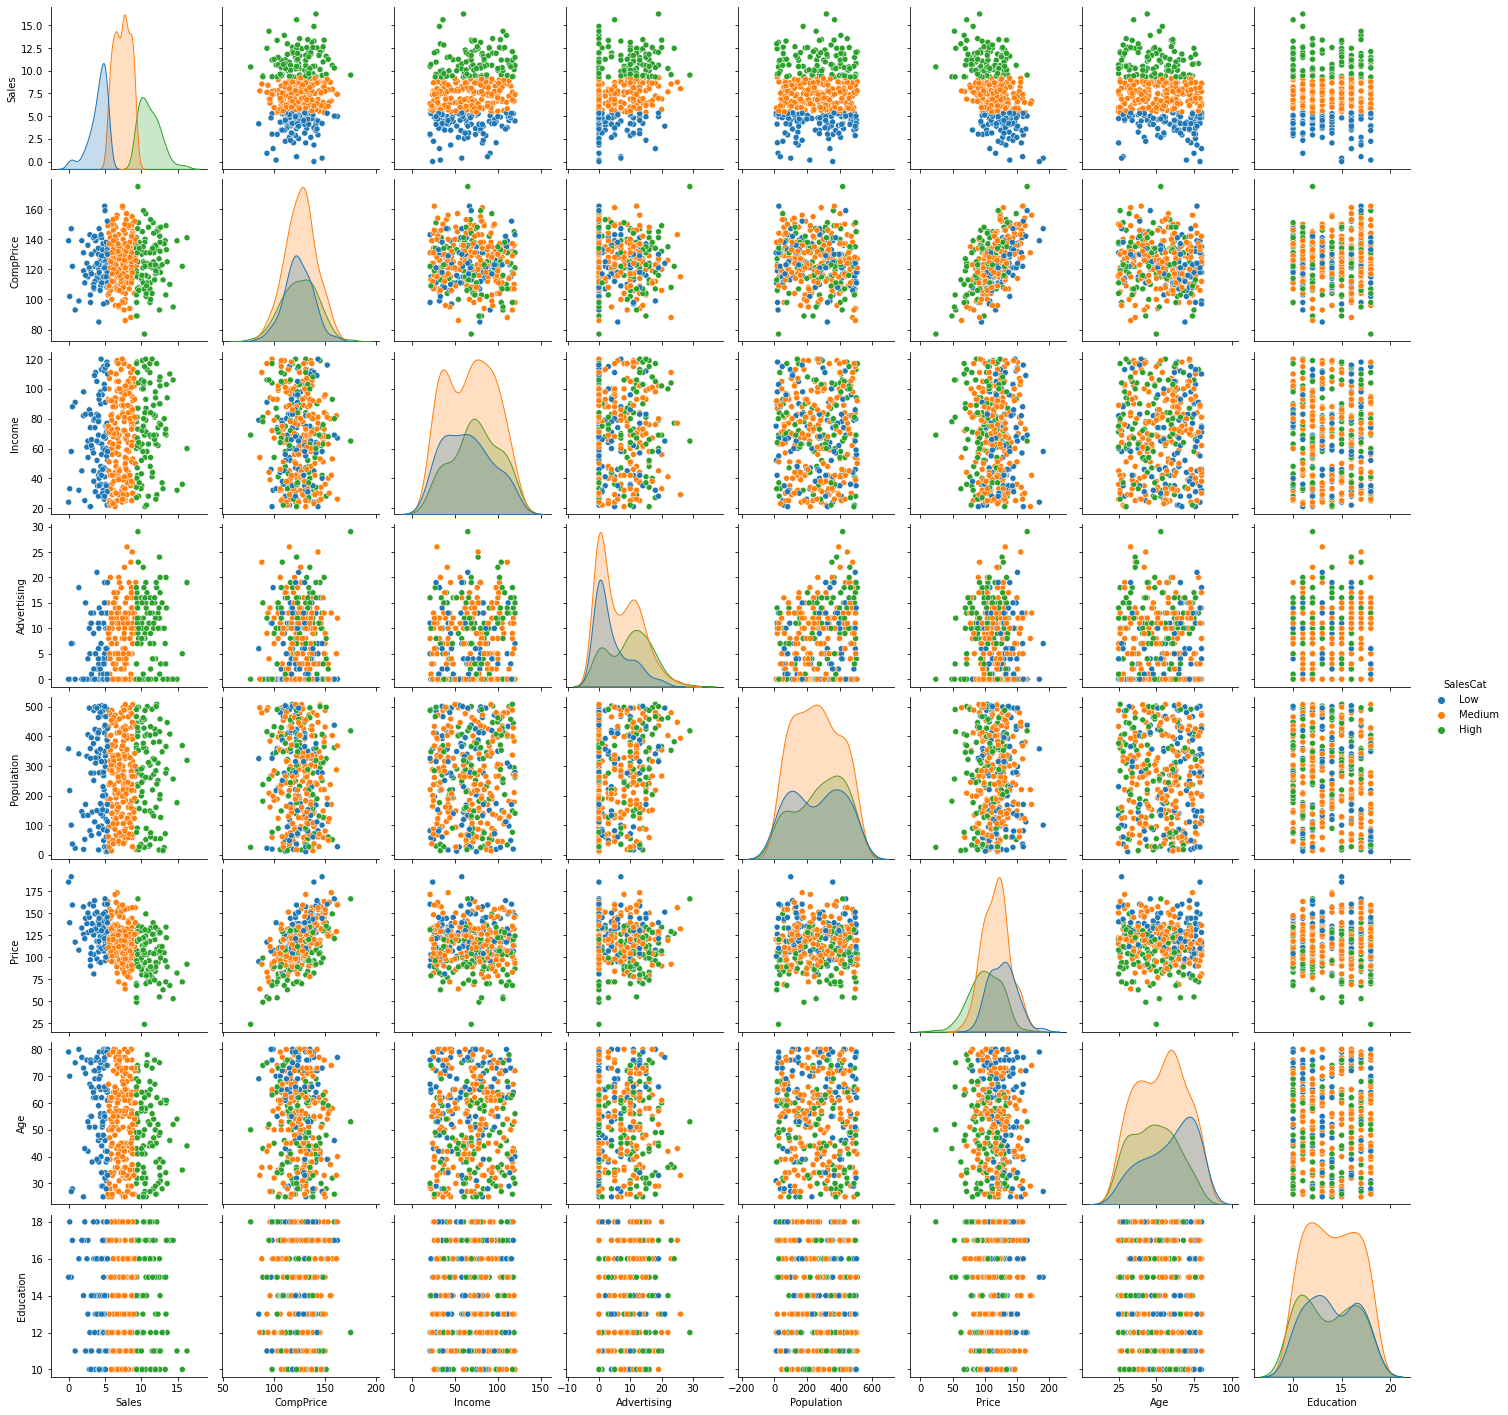

In [25]:
sns.pairplot(data= company_data1, hue = 'SalesCat')
plt.show()

In [26]:
company_data_dummi = company_data1.copy()
company_data_dummi.drop('Sales',axis=1, inplace =True)
company_data_dummi = pd.get_dummies(company_data_dummi.iloc[:,:-1])
company_data_dummi.head()

CompPrice  Income  Advertising  Population  Price  Age  Education  \
0        138      73           11         276    120   42         17   
1        111      48           16         260     83   65         10   
2        113      35           10         269     80   59         12   
3        117     100            4         466     97   55         14   
4        141      64            3         340    128   38         13   

   ShelveLoc_Bad  ShelveLoc_Good  ShelveLoc_Medium  Urban_No  Urban_Yes  \
0              1               0                 0         0          1   
1              0               1                 0         0          1   
2              0               0                 1         0          1   
3              0               0                 1         0          1   
4              1               0                 0         0          1   

   US_No  US_Yes  
0      0       1  
1      0       1  
2      0       1  
3      0       1  
4      1       0

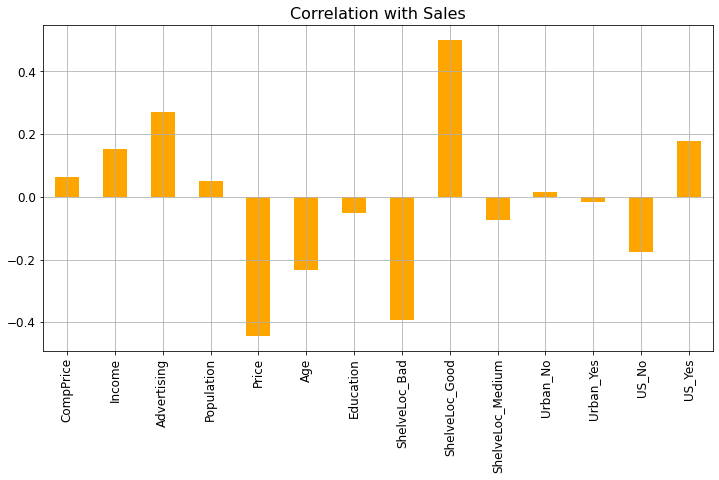

In [27]:
company_data2 = company_data_dummi.copy()

correlations = company_data2.corrwith(company_data1.Sales)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations = correlations[correlations <0].sort_values(ascending = False)

correlations.plot.bar(figsize = (12,6), fontsize = 12, color = 'orange', rot = 90, grid = True)
plt.title('Correlation with Sales',fontsize = "16")
plt.show()

#### Checking for Imbalanced or balanced dataset with regards to the Target

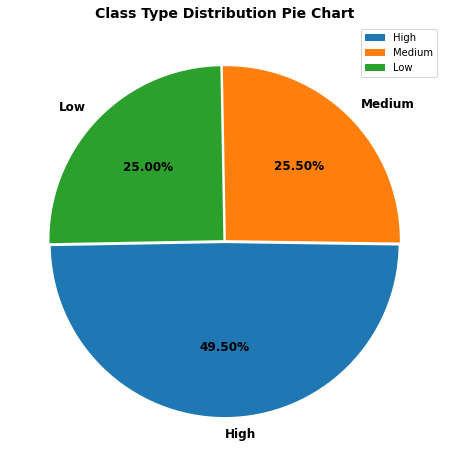

In [28]:
plt.figure(figsize = (9,8))
plt.pie(company_data1['SalesCat'].value_counts(), labels= company_data1.SalesCat.unique(), explode = [0.01,0.01,0.01],
       autopct= '%.2f%%', startangle= 181, textprops = {'size':'large','fontweight':'bold','rotation':'0','color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 14, fontweight = 'bold')
plt.show()

In [29]:
company_data1.SalesCat.value_counts()

Medium    198
High      102
Low       100
Name: SalesCat, dtype: int64

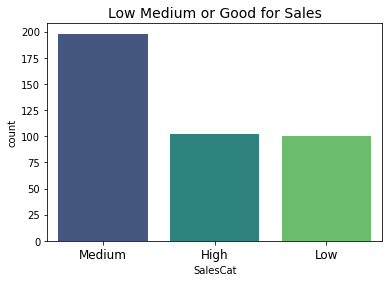

In [30]:
sns.countplot(x= 'SalesCat', data= company_data1, palette= 'viridis', order= company_data1['SalesCat'].value_counts().index)
plt.xticks(fontsize= 12)
plt.title('Low Medium or Good for Sales', fontsize= 14)
plt.show()

#### Data Pre-Processing

In [31]:
company_data3 = company_data1.copy()
company_data3.drop('Sales',axis=1, inplace =True)
company_data3 = pd.get_dummies(company_data3.iloc[:,:-1])
company_data3.head()


CompPrice  Income  Advertising  Population  Price  Age  Education  \
0        138      73           11         276    120   42         17   
1        111      48           16         260     83   65         10   
2        113      35           10         269     80   59         12   
3        117     100            4         466     97   55         14   
4        141      64            3         340    128   38         13   

   ShelveLoc_Bad  ShelveLoc_Good  ShelveLoc_Medium  Urban_No  Urban_Yes  \
0              1               0                 0         0          1   
1              0               1                 0         0          1   
2              0               0                 1         0          1   
3              0               0                 1         0          1   
4              1               0                 0         0          1   

   US_No  US_Yes  
0      0       1  
1      0       1  
2      0       1  
3      0       1  
4      1       0

In [32]:
company_data3['Sales'] = company_data1.SalesCat
company_data3.head()

CompPrice  Income  Advertising  Population  Price  Age  Education  \
0        138      73           11         276    120   42         17   
1        111      48           16         260     83   65         10   
2        113      35           10         269     80   59         12   
3        117     100            4         466     97   55         14   
4        141      64            3         340    128   38         13   

   ShelveLoc_Bad  ShelveLoc_Good  ShelveLoc_Medium  Urban_No  Urban_Yes  \
0              1               0                 0         0          1   
1              0               1                 0         0          1   
2              0               0                 1         0          1   
3              0               0                 1         0          1   
4              1               0                 0         0          1   

   US_No  US_Yes   Sales  
0      0       1    High  
1      0       1    High  
2      0       1    High  
3      0       1  Medium  
4      1       0     Low

#### Lable Encoding

In [33]:
le = LabelEncoder()
le.fit(company_data3["Sales"])
company_data3["Sales"]=le.transform(company_data3["Sales"])
company_data3.head()

CompPrice  Income  Advertising  Population  Price  Age  Education  \
0        138      73           11         276    120   42         17   
1        111      48           16         260     83   65         10   
2        113      35           10         269     80   59         12   
3        117     100            4         466     97   55         14   
4        141      64            3         340    128   38         13   

   ShelveLoc_Bad  ShelveLoc_Good  ShelveLoc_Medium  Urban_No  Urban_Yes  \
0              1               0                 0         0          1   
1              0               1                 0         0          1   
2              0               0                 1         0          1   
3              0               0                 1         0          1   
4              1               0                 0         0          1   

   US_No  US_Yes  Sales  
0      0       1      0  
1      0       1      0  
2      0       1      0  
3      0       1      2  
4      1       0      1

#### Split into input (x) and output (y) variables

In [34]:
x = company_data3.iloc[:, :-1]
y=  company_data3.Sales

#### Feature extraction

In [36]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(x, y)

#### Summarize scores

In [37]:
scores = fit.scores_
features = fit.transform(x)

In [38]:
score_company_data = pd.DataFrame(list(zip(x.columns, scores)), columns =['Feature','Score'])
score_company_data.sort_values(by="Score", ascending=False, inplace=True)
score_company_data

Feature       Score
4              Price  300.881058
2        Advertising  251.767458
3         Population  141.113336
5                Age  106.577639
8     ShelveLoc_Good   66.174919
1             Income   65.145403
7      ShelveLoc_Bad   48.524460
12             US_No   13.109136
9   ShelveLoc_Medium    8.654770
13            US_Yes    7.215106
0          CompPrice    2.253637
6          Education    0.689685
10          Urban_No    0.163751
11         Urban_Yes    0.068520

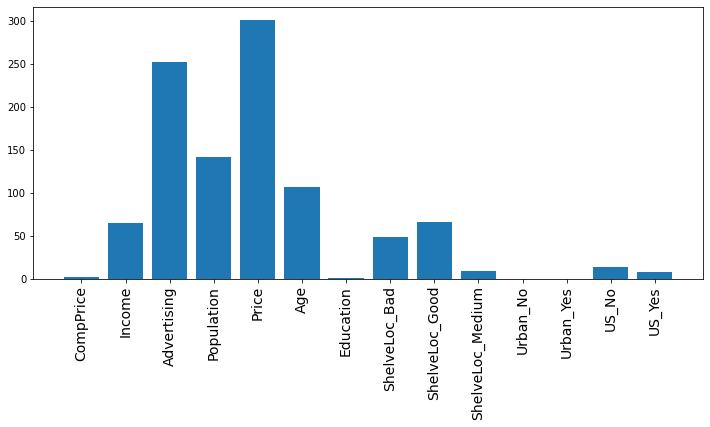

In [39]:
fig, axes = plt.subplots(figsize=(12,5))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation= 90, size= 14)
plt.show()

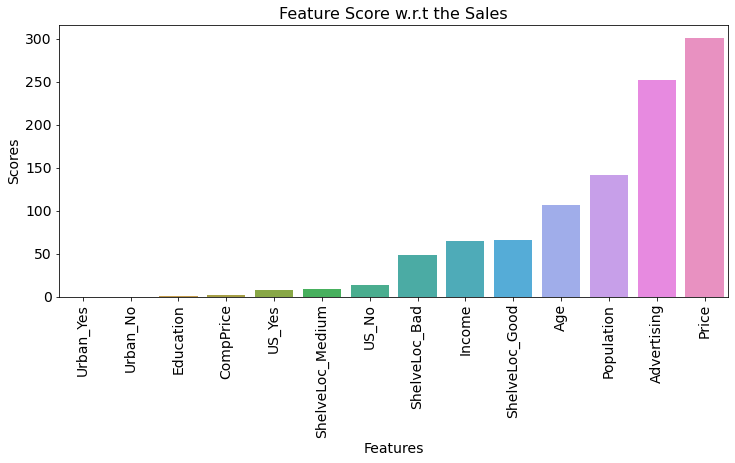

In [40]:
plt.figure(figsize=(12,5))
sns.barplot(x='Feature', y="Score", data= score_company_data, order=score_company_data.sort_values('Score').Feature)
plt.xlabel("Features", size=14)
plt.ylabel("Scores", size=14)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Score w.r.t the Sales", size=16)
plt.show()


In [41]:
model_data = company_data3[['Price', 'Advertising','Population', 'Income', 'Age', 'ShelveLoc_Good', 'ShelveLoc_Bad', 'ShelveLoc_Medium','Sales']]
model_data.head()

Price  Advertising  Population  Income  Age  ShelveLoc_Good  ShelveLoc_Bad  \
0    120           11         276      73   42               0              1   
1     83           16         260      48   65               1              0   
2     80           10         269      35   59               0              0   
3     97            4         466     100   55               0              0   
4    128            3         340      64   38               0              1   

   ShelveLoc_Medium  Sales  
0                 0      0  
1                 0      0  
2                 1      0  
3                 1      2  
4                 0      1

#### Random Forest Built-in Feature Importance

In [42]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)
rf_classifier.fit(x, y)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {'max_depth': [2,3,5,10,20], 'min_samples_leaf': [5,10,20,50,100,200], 'n_estimators': [10,25,30,50,100,200]}

grid_search = GridSearchCV(estimator= rf, param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(x, y)
rf_best = grid_search.best_estimator_

print('Checking the oob score :', rf_classifier.oob_score_)
print('Best Score             :', grid_search.best_score_)
print('RF Best Model          :', rf_best)

Fitting 4 folds for each of 180 candidates, totalling 720 fits
Checking the oob score : 0.635
Best Score             : 0.66
RF Best Model          : RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)


#### Feature Importance

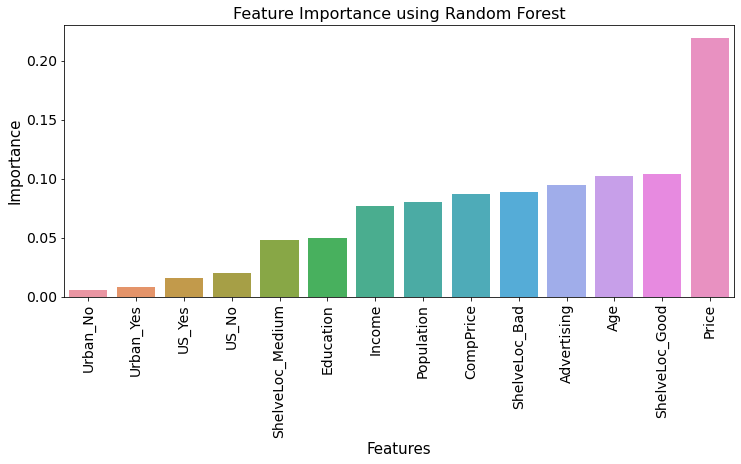

In [43]:
rf_best.feature_importances_
imp_df = pd.DataFrame({"Feature": x.columns, "Importance": rf_best.feature_importances_})

plt.figure(figsize=(12,5))
sns.barplot(x= 'Feature', y= "Importance", data= imp_df, order= imp_df.sort_values('Importance').Feature)
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Importance using Random Forest", size=16)
plt.show()


#### Test Train Split With Imbalanced Dataset

In [44]:
x = model_data.drop('Sales',axis=1)
y = model_data['Sales']

In [45]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [46]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)


Shape of x_train :  (280, 8)
Shape of x_test  :  (120, 8)
Shape of y_train :  (280,)
Shape of y_test  :  (120,)


#### StratifiedKFold

In [47]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_x, test_x = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]

# summarize train and test composition
counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data :',counter_train)
print('Testing Data  :',counter_test)

Training Data : Counter({2: 178, 0: 92, 1: 90})
Testing Data  : Counter({2: 20, 1: 10, 0: 10})


- Stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

#### Grid search using Stratified Kfold Splits on Imbalanced Dataset

In [48]:
def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        pred = clf.predict(x_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n==========================================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("__________________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("__________________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(x_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n==========================================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("__________________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("__________________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [49]:
rf_clf1 = RandomForestClassifier(n_estimators=100)
rf_clf1.fit(train_x, train_y)

print_score(rf_clf1, train_x, train_y, test_x, test_y, train=True)
print_score(rf_clf1, train_x, train_y, test_x, test_y, train=False)

Train Result:
Accuracy Score: 100.00%
__________________________________________________________________________
CLASSIFICATION REPORT:
              0     1      2  accuracy  macro avg  weighted avg
precision   1.0   1.0    1.0       1.0        1.0           1.0
recall      1.0   1.0    1.0       1.0        1.0           1.0
f1-score    1.0   1.0    1.0       1.0        1.0           1.0
support    92.0  90.0  178.0       1.0      360.0         360.0
__________________________________________________________________________
Confusion Matrix: 
 [[ 92   0   0]
 [  0  90   0]
 [  0   0 178]]

Test Result:
Accuracy Score: 52.50%
__________________________________________________________________________
CLASSIFICATION REPORT:
                   0     1          2  accuracy  macro avg  weighted avg
precision   0.800000   0.4   0.520000     0.525   0.573333      0.560000
recall      0.400000   0.4   0.650000     0.525   0.483333      0.525000
f1-score    0.533333   0.4   0.577778     0.525  

#### Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset


In [50]:
rf_clf2 = RandomForestClassifier(n_estimators=100)
rf_clf2.fit(x_train, y_train)

print_score(rf_clf2, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf2, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
__________________________________________________________________________
CLASSIFICATION REPORT:
              0     1      2  accuracy  macro avg  weighted avg
precision   1.0   1.0    1.0       1.0        1.0           1.0
recall      1.0   1.0    1.0       1.0        1.0           1.0
f1-score    1.0   1.0    1.0       1.0        1.0           1.0
support    71.0  70.0  139.0       1.0      280.0         280.0
__________________________________________________________________________
Confusion Matrix: 
 [[ 71   0   0]
 [  0  70   0]
 [  0   0 139]]

Test Result:
Accuracy Score: 66.67%
__________________________________________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy   macro avg  weighted avg
precision   0.758621   0.625000   0.641791  0.666667    0.675137      0.667774
recall      0.709677   0.500000   0.728814  0.666667    0.646164      0.666667
f1-score    0.733333   0.555556

#### Observation:
- In both the condition, due to imbalanced dataset our results are getting biased towards the majority. The model is correctly classifying all the majority classes yet fails to classify the minority classes. Hence, we need to use some kind of oversampling techniques to balance the dataset.

#### Handling imbalance data using SMOTE based techniques

Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. 

There are broadly two types of methods for this 

i) Undersampling 

ii) Oversampling. 

In most cases, oversampling is preferred over undersampling techniques. 

The reason being, in undersampling we tend to remove instances from data that may be carrying some important information. 

In this article,We are specifically covering some special data augmentation oversampling techniques: SMOTE and its related counterparts.

In [52]:
x = model_data.drop(['Sales'], axis=1)
y = model_data['Sales']

In [53]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (280, 8)
Shape of x_test  :  (120, 8)
Shape of y_train :  (280,)
Shape of y_test  :  (120,)


#### SMOTE Oversampling technique

In [54]:
counter1 = Counter(y_train)
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)
counter2 = Counter(y_train_sm)

print('Before :',counter1)
print('After  :',counter2)

Before : Counter({2: 139, 0: 71, 1: 70})
After  : Counter({2: 139, 1: 139, 0: 139})


#### ADASYN: Adaptive Synthetic Sampling Approach

In [55]:
counter1 = Counter(y_train)
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)
counter2 = Counter(y_train_ada)

print('Before :',counter1)
print('After  :',counter2)

Before : Counter({2: 139, 0: 71, 1: 70})
After  : Counter({1: 140, 2: 139, 0: 139})


#### Hybridization: SMOTE + Tomek Links


In [56]:
counter1 = Counter(y_train)
smtom = SMOTETomek(random_state=139)
x_train_smtom, y_train_smtom = smtom.fit_resample(x_train, y_train)
counter2 = Counter(y_train_smtom)

print('Before :',counter1)
print('After  :',counter2)

Before : Counter({2: 139, 0: 71, 1: 70})
After  : Counter({0: 128, 1: 127, 2: 118})


#### Hybridization: SMOTE + ENN

In [57]:
counter1 = Counter(y_train)
smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)
counter2 = Counter(y_train_smenn)

print('Before :',counter1)
print('After  :',counter2)

Before : Counter({2: 139, 0: 71, 1: 70})
After  : Counter({1: 62, 0: 50, 2: 13})


####  Performance Analysis after Resampling

In [58]:
sample_data = {'ACTUAL':[x_train, y_train], 'SMOTE':[x_train_sm, y_train_sm], 'ADASYN':[x_train_ada, y_train_ada],
               'SMOTE_TOMEK':[x_train_smtom, y_train_smtom], 'SMOTE_ENN':[x_train_smenn, y_train_smenn]}

In [59]:
def test_eval(clf_model, x_test, y_test, algo= None, sampling=None):
    # Test set prediction
    y_prob = clf_model.predict_proba(x_test)
    y_pred = clf_model.predict(x_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    
    f1        = f1_score(y_test, y_pred, average='micro')
    recall    = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
          
    return algo,precision,recall,f1,sampling

In [60]:
model_params = {'random-forest' : {'model' : RandomForestClassifier(), 'params' : {"n_estimators": [5, 10, 15, 20, 25], 
                'max_depth': [i for i in range(5,16,2)], 'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
                'min_samples_leaf': [1, 2, 5], 'criterion': ['gini', 'entropy'], 'max_features': ['log2', 'sqrt', 'auto']}}}


In [61]:
cv = StratifiedKFold (n_splits=5, random_state=100, shuffle=True)
output = []
for model, model_hp in model_params.items():
    for resampl, data in sample_data.items():
        clf3 = RandomizedSearchCV (model_hp['model'], model_hp['params'], cv = cv, scoring='roc_auc', n_jobs=-1 )
        clf3.fit(data[0], data[1])
        clf_best1 = clf3.best_estimator_
        print('='*60)
        print(model+' with ' + resampl)
        print('-'*60)
        output.append(test_eval(clf_best1, x_test, y_test, model, resampl))


random-forest with ACTUAL
------------------------------------------------------------
Confusion Matrix
[[16  1 14]
 [ 0 15 15]
 [ 6 12 41]] 

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.52      0.60        31
           1       0.54      0.50      0.52        30
           2       0.59      0.69      0.64        59

    accuracy                           0.60       120
   macro avg       0.62      0.57      0.59       120
weighted avg       0.61      0.60      0.60       120
 

random-forest with SMOTE
------------------------------------------------------------
Confusion Matrix
[[27  1  3]
 [ 1 15 14]
 [15 17 27]] 

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.87      0.73        31
           1       0.45      0.50      0.48        30
           2       0.61      0.46      0.52        59

    accuracy                           0.57       120
   macro avg    

#### Observations:
- ADASYN technique gave the best results we are going to use it further

In [62]:
counter1 = Counter(y_train)
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)
counter2 = Counter(y_train_ada)

print('Before :',counter1)
print('After  :',counter2)

Before : Counter({2: 139, 0: 71, 1: 70})
After  : Counter({1: 140, 2: 139, 0: 139})


In [63]:
x_train,x_test,y_train,y_test = train_test_split(x_train_ada,y_train_ada,test_size=0.3,random_state=0, stratify=y_train_ada)

counter1 = Counter(y_train_ada)
counter2 = Counter(y_train)
print('Before           :',counter1)
print('After            :',counter2)
print("Shape of X_train : ",x_train.shape)
print("Shape of X_test  : ", x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Before           : Counter({1: 140, 2: 139, 0: 139})
After            : Counter({1: 98, 0: 97, 2: 97})
Shape of X_train :  (292, 8)
Shape of X_test  :  (126, 8)
Shape of y_train :  (292,)
Shape of y_test  :  (126,)


#### Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting

#### Random Forest hyperparameter tuning

#### Base model

In [64]:
score_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 12) 
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))

In [65]:
loc = np.array(score_array).max()
score_array.index(loc)+1

42

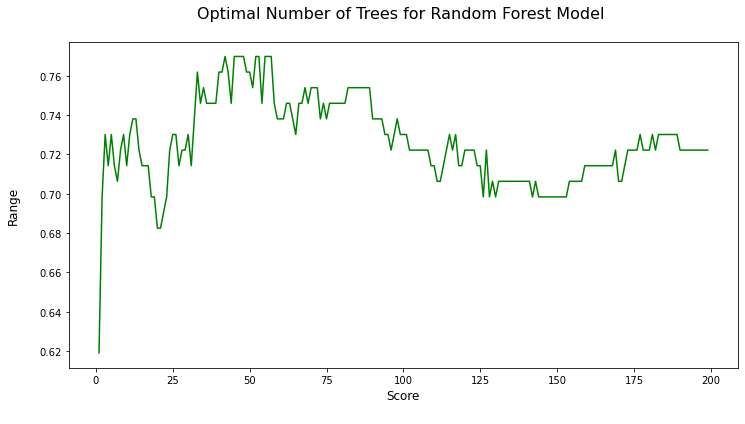

In [66]:
fig = plt.figure(figsize=(12,6))
plt.plot(range(1,200),score_array, color = 'g')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n', horizontalalignment="center", fontsize = 16)
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

#### Randomized Search Cross Validation

In [67]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)
rf_cv = RandomizedSearchCV (estimator=rf_clf, scoring='f1',param_distributions=random_grid,
                            n_iter=100, cv=3,verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 195, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True})
Train Result:
Accuracy Score: 91.44%
__________________________________________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy   macro avg  weighted avg
precision   0.957447   0.879630   0.911111  0.914384    0.916063      0.915938
recall      0.927835   0.969388   0.845361  0.914384    0.914195      0.914384
f1-score    0.942408   0.922330   0.877005  0.914384    0.913915      0.913943
support    97.000000  98.000000  97.000000  0.914384  292.000000    292.000000
__________________________________________________________________________
Confusion Matrix: 
 [[90  2  5]
 [ 0 95  3]
 [ 4 11 82]]

Test Result:
Accuracy Score: 73.02%
__________________________________________________________________________
CLASSIFICATION RE

Random search allowed us to narrow down the range for each hyperparameter. 

Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try.

#### Visualizing one of the decision tree in random forest

In [68]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=50, min_samples_leaf=4, n_estimators=195,
                       random_state=42)

In [69]:
company_data1.SalesCat.unique()

['High', 'Medium', 'Low']
Categories (3, object): ['Low' < 'Medium' < 'High']

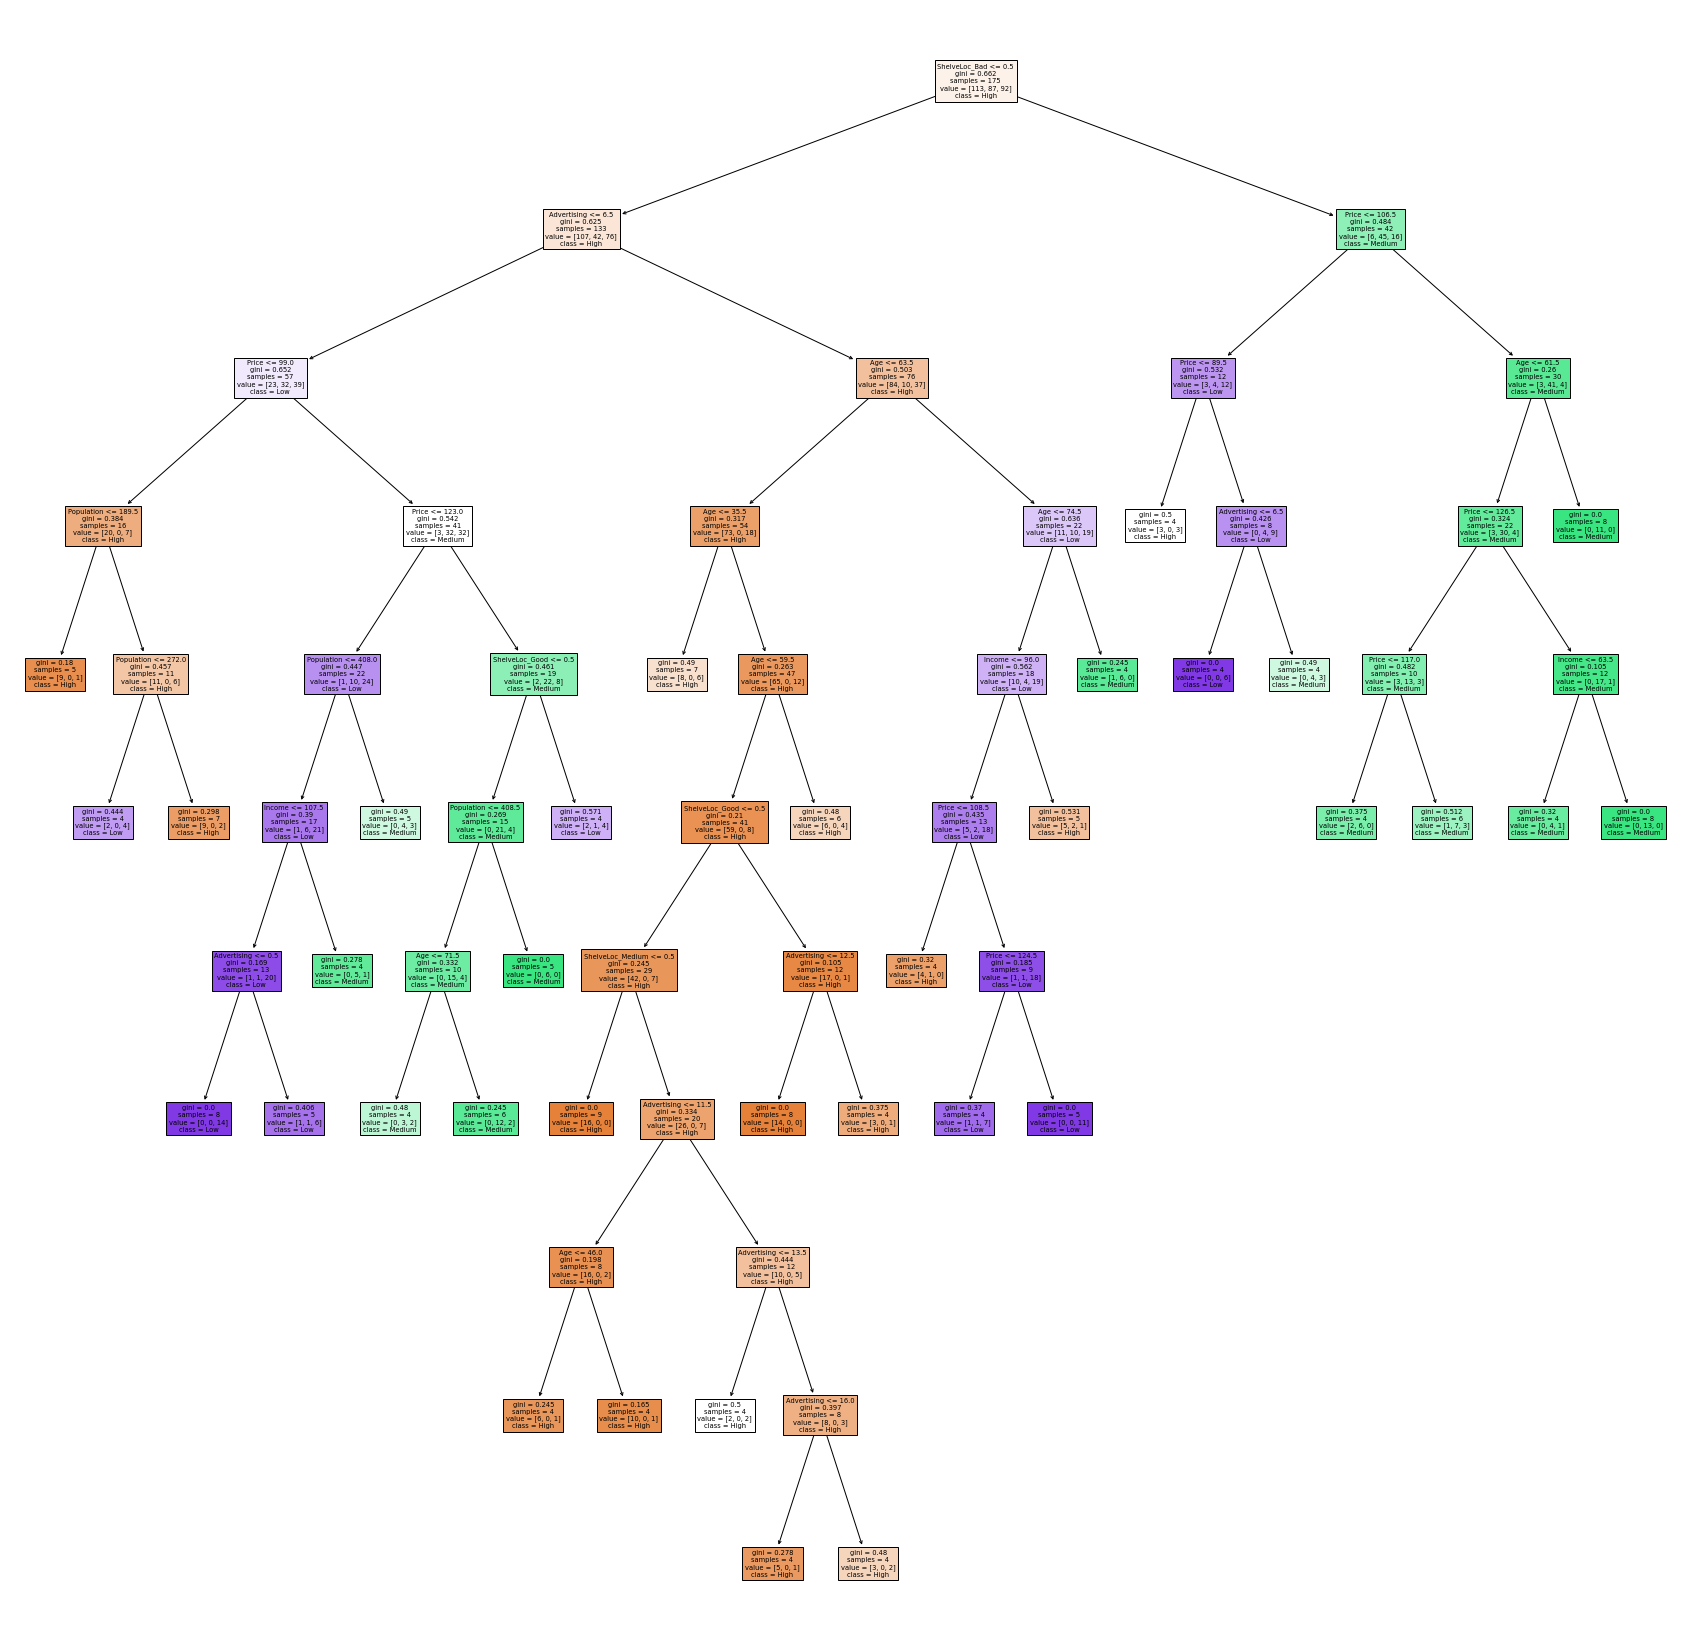

In [75]:
plt.figure(figsize=(30,30))
plot_tree(rf_best.estimators_[190], feature_names = model_data.columns,class_names=company_data1.SalesCat.unique(),
          filled=True)
plt.show()

#### Model Deployement

In [76]:
from pickle import dump
dump(rf_clf,open('company_data_intell.pkl','wb'))

# Problem Statement 2 :

Use Random Forest to prepare a model on fraud data
Treating those who have taxable_income <= 30000 as "Risky" and others are "Good"


Data description:

- Undergrad : person is under graduated or not
- Marital.Status : marital status of a person
- Taxable.Income : Taxable income is the amount of how much tax an individual owes to the government
- Work Experience : Work experience of an individual person
- Urban : Whether that person belongs to urban area or not


#### Load Dataset

In [78]:
fraud_check = pd.read_csv('Fraud_Check.csv')
fraud_check

Undergrad Marital.Status  Taxable.Income  City.Population  \
0          NO         Single           68833            50047   
1         YES       Divorced           33700           134075   
2          NO        Married           36925           160205   
3         YES         Single           50190           193264   
4          NO        Married           81002            27533   
..        ...            ...             ...              ...   
595       YES       Divorced           76340            39492   
596       YES       Divorced           69967            55369   
597        NO       Divorced           47334           154058   
598       YES        Married           98592           180083   
599        NO       Divorced           96519           158137   

     Work.Experience Urban  
0                 10   YES  
1                 18   YES  
2                 30   YES  
3                 15   YES  
4                 28    NO  
..               ...   ...  
595                7   YES  
596                2   YES  
597                0   YES  
598               17    NO  
599               16    NO  

[600 rows x 6 columns]

#### EDA

In [79]:
fraud_check.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [80]:
fraud_check.shape

(600, 6)

In [81]:
fraud_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [82]:
fraud_check[fraud_check.duplicated()].shape

(0, 6)

In [83]:
fraud_check.describe()

Taxable.Income  City.Population  Work.Experience
count      600.000000       600.000000       600.000000
mean     55208.375000    108747.368333        15.558333
std      26204.827597     49850.075134         8.842147
min      10003.000000     25779.000000         0.000000
25%      32871.500000     66966.750000         8.000000
50%      55074.500000    106493.500000        15.000000
75%      78611.750000    150114.250000        24.000000
max      99619.000000    199778.000000        30.000000

In [84]:
fraud_check['Taxable.Income'].describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: Taxable.Income, dtype: float64

Converting taxable_income <= 30000 as "Risky" and others are "Good"

In [85]:
fraud_check1 = fraud_check.copy()
fraud_check1['Taxable.Category'] = pd.cut(x = fraud_check1['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
fraud_check1.head()

Undergrad Marital.Status  Taxable.Income  City.Population  Work.Experience  \
0        NO         Single           68833            50047               10   
1       YES       Divorced           33700           134075               18   
2        NO        Married           36925           160205               30   
3       YES         Single           50190           193264               15   
4        NO        Married           81002            27533               28   

  Urban Taxable.Category  
0   YES             Good  
1   YES             Good  
2   YES             Good  
3   YES             Good  
4    NO             Good

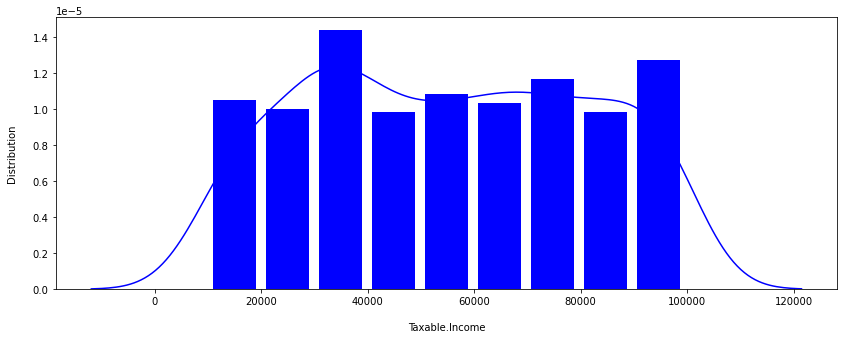

In [86]:
def distplot(param):
    plt.figure(figsize= (14,5))
    sns.distplot(fraud_check[param], color= "blue", hist_kws={"rwidth":0.80, 'alpha':1.0})
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
distplot("Taxable.Income")

In [87]:
fraud_check1['Taxable.Category'].value_counts()

Good     476
Risky    124
Name: Taxable.Category, dtype: int64

In [88]:
fraud_check1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Undergrad         600 non-null    object  
 1   Marital.Status    600 non-null    object  
 2   Taxable.Income    600 non-null    int64   
 3   City.Population   600 non-null    int64   
 4   Work.Experience   600 non-null    int64   
 5   Urban             600 non-null    object  
 6   Taxable.Category  600 non-null    category
dtypes: category(1), int64(3), object(3)
memory usage: 29.0+ KB


In [89]:
categorical_features = fraud_check1.describe(include=["object"]).columns
categorical_features


Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')

In [90]:
numerical_features = fraud_check1.describe(include=["int64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

#### Univariate plots

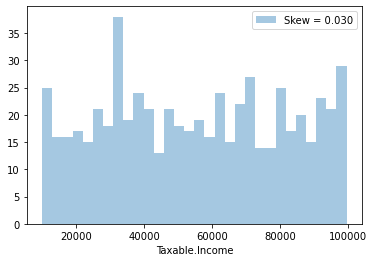

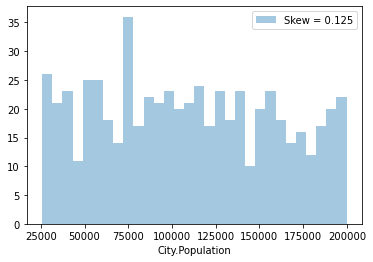

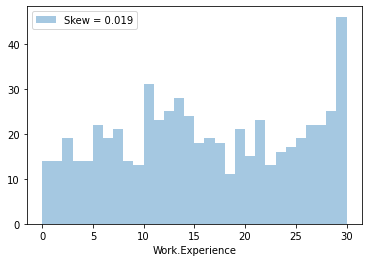

In [91]:
numerical_features=[feature for feature in fraud_check.columns if fraud_check[feature].dtypes != 'O']
for feat in numerical_features:
    skew = fraud_check[feat].skew()
    sns.distplot(fraud_check[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

#### Observation
- None of the features is normally distributed.

#### Outliers

In [92]:
numerical_features

['Taxable.Income', 'City.Population', 'Work.Experience']

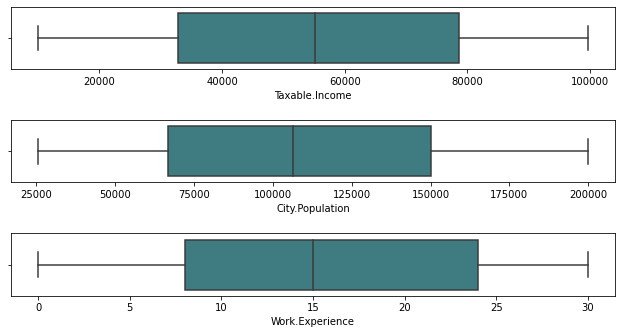

In [93]:
outlier = fraud_check.copy() 
fig, axes = plt.subplots(3,1,figsize=(9,5),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data= outlier,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data= outlier,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data= outlier,palette='crest',ax=axes[2])
plt.tight_layout(pad=2.0)

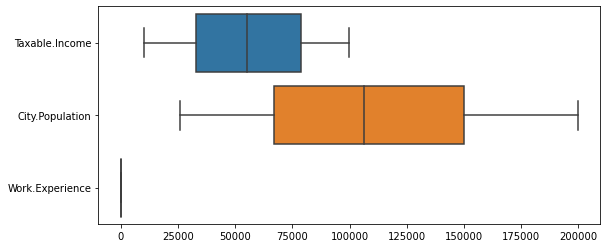

In [94]:
plt.figure(figsize=(9,4))
sns.boxplot(data= fraud_check[numerical_features], orient="h")
plt.show()

#### Observation:
- Work Experience has a mean which is very less

#### Multivariate Analysis

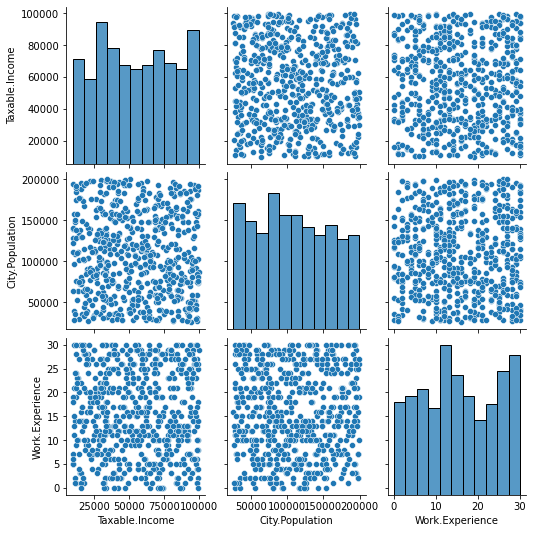

In [95]:
sns.pairplot(fraud_check, palette='coolwarm')
plt.show()

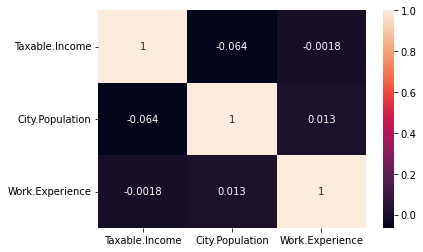

In [98]:
#correlation matrix
sns.heatmap(fraud_check.corr(), annot=True)
plt.show()

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')


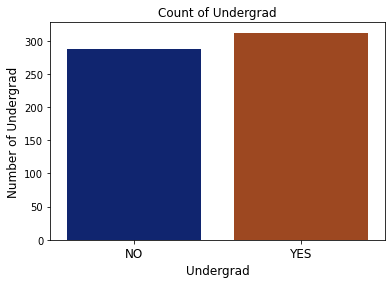

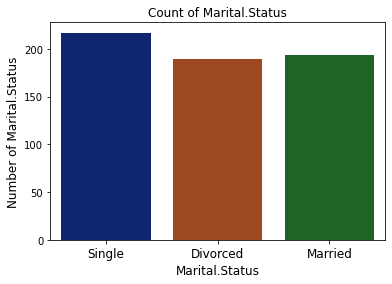

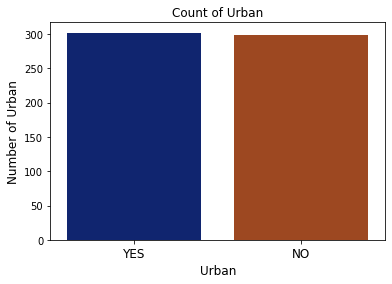

In [99]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(6,4))
    unique = fraud_check[column].value_counts(ascending=True);
   
    plt.title("Count of "+ column)
    sns.countplot(data= fraud_check1, x=column, palette = "dark")
    plt.xticks(rotation = 0, size = 12)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

In [100]:
def factorplot(param):
    sns.factorplot(x= param, size= 5, aspect= 2, data= fraud_check, y= "Taxable.Income", palette= "dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Taxable Income\n")
    plt.show()

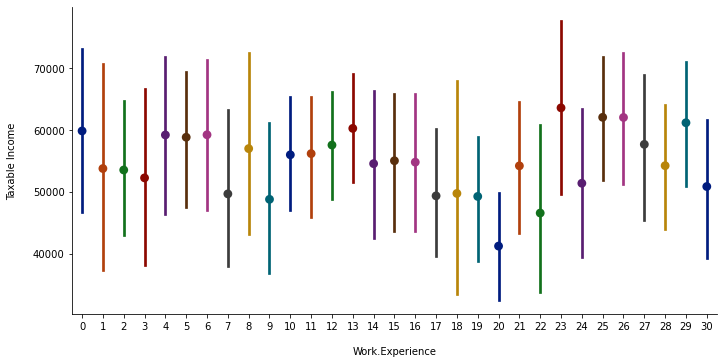

In [101]:
factorplot("Work.Experience")

#### Pair plot

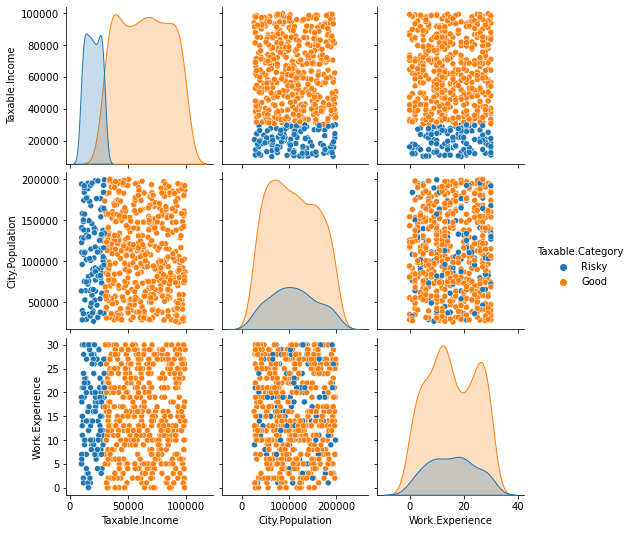

In [102]:
sns.pairplot(data= fraud_check1, hue = 'Taxable.Category')
plt.show()

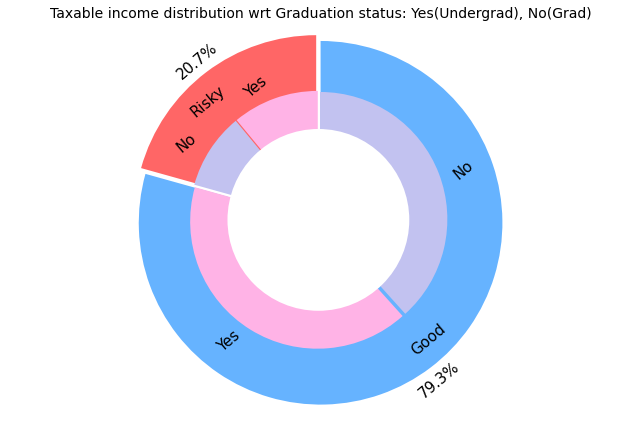

In [103]:
plt.figure(figsize=(9,6))
labels =["Risky", "Good"]
values = [fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Risky'].groupby(by = fraud_check1.Undergrad).count().sum(),
         fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Good'].groupby(by = fraud_check1.Undergrad).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [66,58 , 246,230]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15, 'rotation':'40'}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution wrt Graduation status: Yes(Undergrad), No(Grad)', fontsize= 14)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

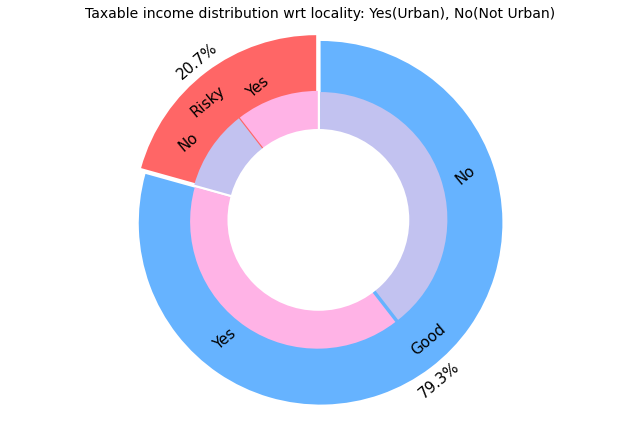

In [104]:
plt.figure(figsize=(9,6))
labels =["Risky", "Good"]
values = [fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Risky'].groupby(by = fraud_check1["Urban"]).count().sum(),
         fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Good'].groupby(by = fraud_check1["Urban"]).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [63,61 , 239,237]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15, 'rotation':'40'}
#Plot
plt.pie(values, labels=labels, autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution wrt locality: Yes(Urban), No(Not Urban)', fontsize=14)
 
plt.axis('equal')
plt.tight_layout()
plt.show()


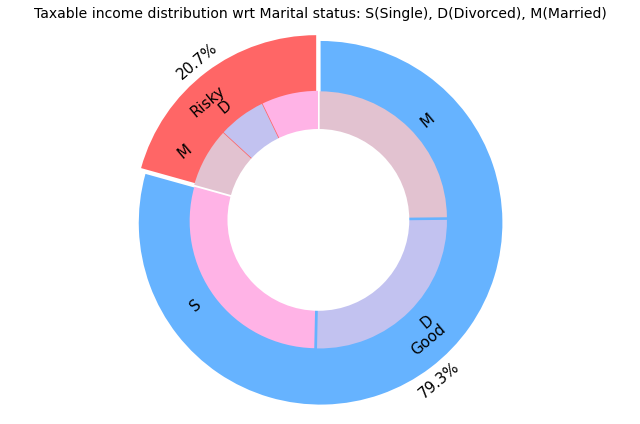

In [105]:
plt.figure(figsize=(9,6))
labels =["Risky", "Good"]
values = [fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Risky'].groupby(by = fraud_check1["Marital.Status"]).count().sum(),
         fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Good'].groupby(by = fraud_check1["Marital.Status"]).count().sum()]
labels_gender = ["","D","M","S","D", "M"]
sizes_gender = [43,36,45,174,153,149]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#e2c2d0','#ffb3e6', '#c2c2f0', '#e2c2d0']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1)
textprops = {"fontsize":15, 'rotation':40}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution wrt Marital status: S(Single), D(Divorced), M(Married)', fontsize=14)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

In [106]:
fraud_check_dummi = fraud_check1.copy()
fraud_check_dummi.drop(['Taxable.Income'],axis=1, inplace =True)
fraud_check_dummi = pd.get_dummies(fraud_check_dummi.iloc[:,:-1])
fraud_check_dummi.head()


City.Population  Work.Experience  Undergrad_NO  Undergrad_YES  \
0            50047               10             1              0   
1           134075               18             0              1   
2           160205               30             1              0   
3           193264               15             0              1   
4            27533               28             1              0   

   Marital.Status_Divorced  Marital.Status_Married  Marital.Status_Single  \
0                        0                       0                      1   
1                        1                       0                      0   
2                        0                       1                      0   
3                        0                       0                      1   
4                        0                       1                      0   

   Urban_NO  Urban_YES  
0         0          1  
1         0          1  
2         0          1  
3         0          1  
4         1          0

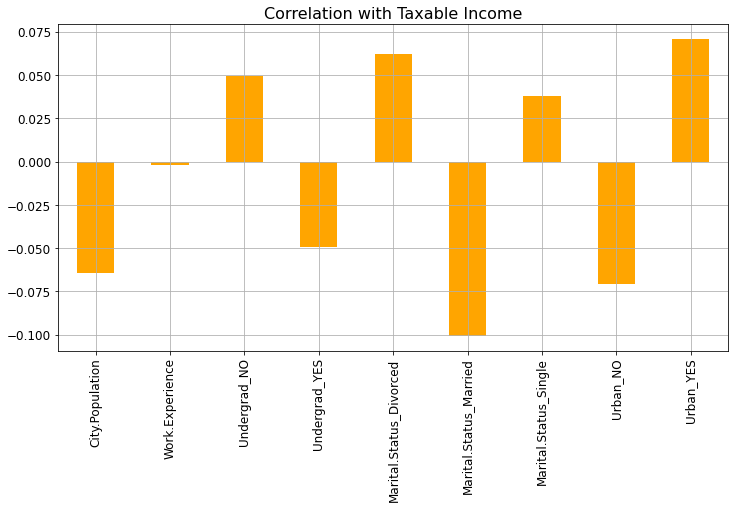

In [107]:
fraud_check2 = fraud_check_dummi.copy()

correlations = fraud_check2.corrwith(fraud_check1['Taxable.Income'])                                     
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(figsize = (12,6), fontsize = 12, color = 'orange', rot = 90, grid = True)
plt.title('Correlation with Taxable Income',fontsize = "16")
plt.show()

#### Checking for Imbalanced or balanced dataset with regards to the Target

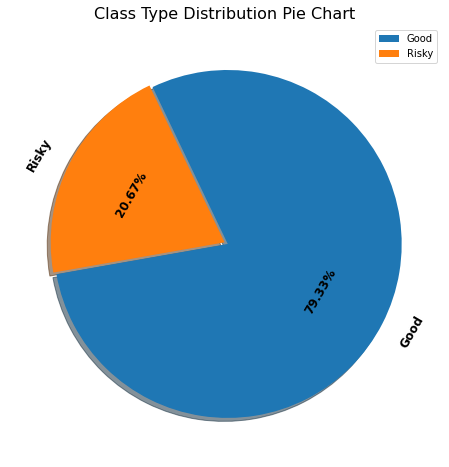

In [108]:
plt.figure(figsize = (9,8))
plt.pie(fraud_check1['Taxable.Category'].value_counts(), labels= fraud_check1['Taxable.Category'].unique(),
       explode = [0.02,0.0], autopct= '%.2f%%', shadow= True, startangle= 190,
       textprops = {'size':'large', 'fontweight':'bold', 'rotation': 60, 'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 16)
plt.show()

The class “Good” is called the majority class, and the much smaller in size “Risky” class is called the minority class.

In [110]:
countNotermdeposit = len(fraud_check1[fraud_check1['Taxable.Category'] == 'Good'])
counthavetermdeposit = len(fraud_check1[fraud_check1['Taxable.Category'] == 'Risky'])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%".format((countNotermdeposit / 
                                                                            (len(fraud_check1['Taxable.Category']))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%".format((counthavetermdeposit / 
                                                                    (len(fraud_check1['Taxable.Category']))*100)))

Percentage of Customer doesn't have a term deposit: 79.33%
Percentage of Customer have a term deposit: 20.67%


In [111]:
fraud_check1['Taxable.Category'].value_counts()

Good     476
Risky    124
Name: Taxable.Category, dtype: int64

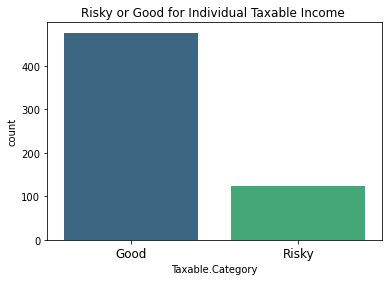

In [112]:
sns.countplot(x='Taxable.Category', data= fraud_check1, palette = 'viridis', 
              order=fraud_check1['Taxable.Category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')
plt.show()

#### Data Pre-Processing

#### Feature Selection Technique

In [113]:
fraud_check1.columns

Index(['Undergrad', 'Marital.Status', 'Taxable.Income', 'City.Population',
       'Work.Experience', 'Urban', 'Taxable.Category'],
      dtype='object')

In [115]:
fraud_check3 = fraud_check1.copy()
fraud_check3.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','City.Population':'City_Population','Work.Experience':'Work_Experience','Taxable.Category':'Taxable_Category'}, inplace = True)
fraud_check3.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = fraud_check3.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'Taxable_Category'], dtype='object')

#### Lable Encoding

#### Creating dummy vairables of the categorical features

In [116]:
fraud_check3.columns

Index(['Undergrad', 'Marital_Status', 'City_Population', 'Work_Experience',
       'Urban', 'Taxable_Category'],
      dtype='object')

In [117]:
le = LabelEncoder()
for col in categorical_features:
        le.fit(fraud_check3[col])
        fraud_check3[col] = le.transform(fraud_check3[col])
fraud_check3.head()

Undergrad  Marital_Status  City_Population  Work_Experience  Urban  \
0          0               2            50047               10      1   
1          1               0           134075               18      1   
2          0               1           160205               30      1   
3          1               2           193264               15      1   
4          0               1            27533               28      0   

   Taxable_Category  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

#### Feature Selection Technique

In [118]:
fraud_check4 = fraud_check1.copy()
fraud_check4.drop('Taxable.Income',axis=1, inplace =True)
fraud_check4 = pd.get_dummies(fraud_check4.iloc[:,:-1])
fraud_check4.head()

City.Population  Work.Experience  Undergrad_NO  Undergrad_YES  \
0            50047               10             1              0   
1           134075               18             0              1   
2           160205               30             1              0   
3           193264               15             0              1   
4            27533               28             1              0   

   Marital.Status_Divorced  Marital.Status_Married  Marital.Status_Single  \
0                        0                       0                      1   
1                        1                       0                      0   
2                        0                       1                      0   
3                        0                       0                      1   
4                        0                       1                      0   

   Urban_NO  Urban_YES  
0         0          1  
1         0          1  
2         0          1  
3         0          1  
4         1          0

In [119]:
fraud_check4['Taxable_Income'] = fraud_check1['Taxable.Category']
fraud_check4.head()

City.Population  Work.Experience  Undergrad_NO  Undergrad_YES  \
0            50047               10             1              0   
1           134075               18             0              1   
2           160205               30             1              0   
3           193264               15             0              1   
4            27533               28             1              0   

   Marital.Status_Divorced  Marital.Status_Married  Marital.Status_Single  \
0                        0                       0                      1   
1                        1                       0                      0   
2                        0                       1                      0   
3                        0                       0                      1   
4                        0                       1                      0   

   Urban_NO  Urban_YES Taxable_Income  
0         0          1           Good  
1         0          1           Good  
2         0          1           Good  
3         0          1           Good  
4         1          0           Good

In [120]:
le = LabelEncoder()
le.fit(fraud_check4["Taxable_Income"])
fraud_check4["Taxable_Income"]=le.transform(fraud_check4["Taxable_Income"])
fraud_check4.head()

City.Population  Work.Experience  Undergrad_NO  Undergrad_YES  \
0            50047               10             1              0   
1           134075               18             0              1   
2           160205               30             1              0   
3           193264               15             0              1   
4            27533               28             1              0   

   Marital.Status_Divorced  Marital.Status_Married  Marital.Status_Single  \
0                        0                       0                      1   
1                        1                       0                      0   
2                        0                       1                      0   
3                        0                       0                      1   
4                        0                       1                      0   

   Urban_NO  Urban_YES  Taxable_Income  
0         0          1               0  
1         0          1               0  
2         0          1               0  
3         0          1               0  
4         1          0               0

#### Split into input (x) and output (y) variables

In [121]:
x = fraud_check4.iloc[:, :-1]
y=  fraud_check4.Taxable_Income

##### Feature extraction

In [122]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(x, y)

##### Summarize scores

In [123]:
scores = fit.scores_
features = fit.transform(x)

In [124]:
score_fraud_check = pd.DataFrame(list(zip(x.columns, scores)), columns =['Feature','Score'])
score_fraud_check.sort_values(by="Score", ascending=False, inplace=True)
score_fraud_check

Feature        Score
0          City.Population  2045.643886
5   Marital.Status_Married     0.756912
4  Marital.Status_Divorced     0.302172
6    Marital.Status_Single     0.095850
2             Undergrad_NO     0.048929
3            Undergrad_YES     0.045165
1          Work.Experience     0.011709
7                 Urban_NO     0.007044
8                Urban_YES     0.006951

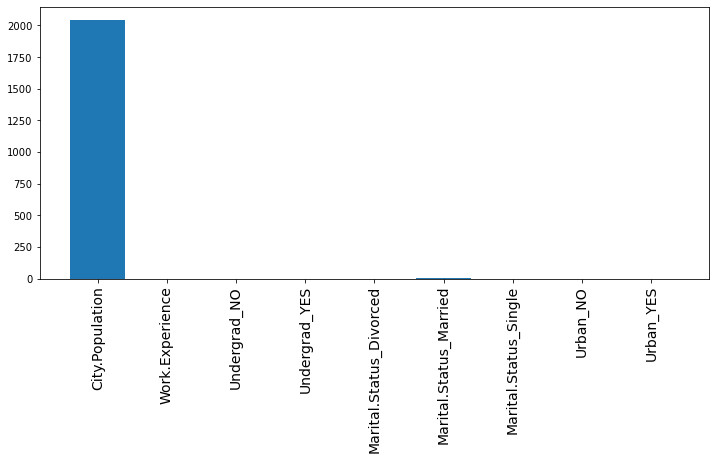

In [125]:
fig, axes = plt.subplots(figsize=(12,5))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 14)
plt.show()


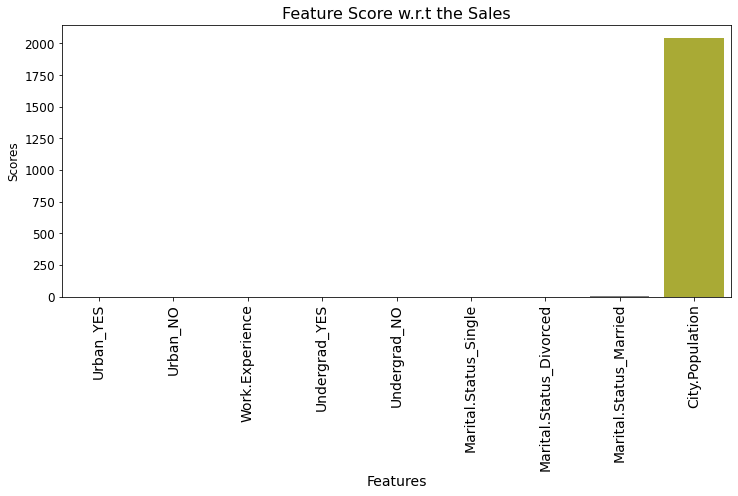

In [126]:
plt.figure(figsize=(12,5))
sns.barplot(x='Feature', y="Score", data=score_fraud_check, order=score_fraud_check.sort_values('Score').Feature)
plt.xlabel("Features", size=14)
plt.ylabel("Scores", size=12)
plt.yticks(rotation = 0, fontsize = 12)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Score w.r.t the Sales", size=16)
plt.show()

#### Random Forest Built-in Feature Importance

In [127]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)
rf_classifier.fit(x, y)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {'max_depth': [2,3,5,10,20], 'min_samples_leaf': [5,10,20,50,100,200],'n_estimators': [10,25,30,50,100,200]}

grid_search = GridSearchCV(estimator= rf, param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(x, y)
rf_best = grid_search.best_estimator_

print('Checking the oob score :', rf_classifier.oob_score_)
print('Best Score             :', grid_search.best_score_)
print('RF Best Model          :', rf_best)

Fitting 4 folds for each of 180 candidates, totalling 720 fits
Checking the oob score : 0.7933333333333333
Best Score             : 0.7933333333333333
RF Best Model          : RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)


#### Sorting the data with the help of feature importance

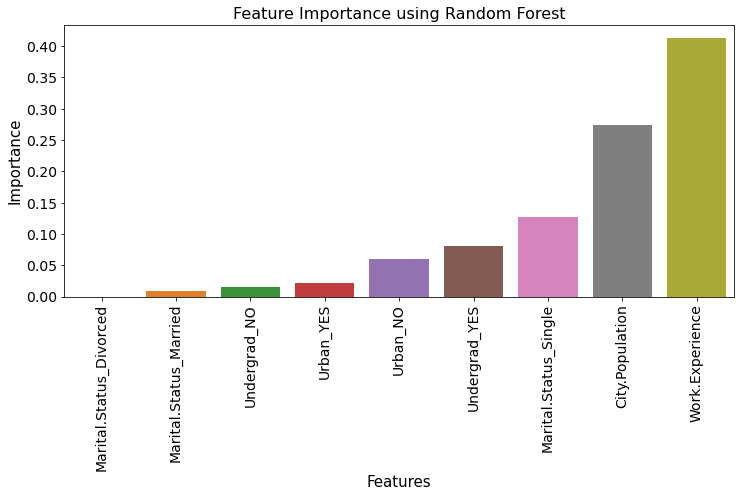

In [128]:
rf_best.feature_importances_
imp_df = pd.DataFrame({"Feature": x.columns, "Importance": rf_best.feature_importances_})

plt.figure(figsize=(12,5))
sns.barplot(x= 'Feature', y= "Importance", data= imp_df, order= imp_df.sort_values('Importance').Feature)
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Importance using Random Forest", size=16)
plt.show()

#### Test Train Split With Imbalanced Dataset

In [129]:
x = fraud_check3.drop('Taxable_Category',axis=1)
y = fraud_check3['Taxable_Category']

In [130]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [131]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (420, 5)
Shape of x_test  :  (180, 5)
Shape of y_train :  (420,)
Shape of y_test  :  (180,)


#### About Stratify

- Stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify

#### StratifiedKFold

In [132]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_x, test_x = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]

# summarize train and test composition
counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data :',counter_train)
print('Testing Data  :',counter_test)

Training Data : Counter({0: 429, 1: 111})
Testing Data  : Counter({0: 47, 1: 13})


####  Grid search using Stratified Kfold Splits on Imbalanced Dataset

In [133]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [134]:
rf_clf1 = RandomForestClassifier(n_estimators=100)
rf_clf1.fit(train_x, train_y)

print_score(rf_clf1, train_x, train_y, test_x, test_y, train=True)
print_score(rf_clf1, train_x, train_y, test_x, test_y, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    429.0  111.0       1.0      540.0         540.0
_______________________________________________
Confusion Matrix: 
 [[429   0]
 [  0 111]]

Test Result:
Accuracy Score: 75.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.785714   0.250000      0.75   0.517857      0.669643
recall      0.936170   0.076923      0.75   0.506547      0.750000
f1-score    0.854369   0.117647      0.75   0.486008      0.694746
support    47.000000  13.000000      0.75  60.000000     60.000000
_______________________________________________
Confusion Matr

#### Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset

In [135]:
rf_clf2 = RandomForestClassifier(n_estimators=100)
rf_clf2.fit(x_train, y_train)

print_score(rf_clf2, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf2, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1  accuracy  macro avg  weighted avg
precision    1.0   1.0       1.0        1.0           1.0
recall       1.0   1.0       1.0        1.0           1.0
f1-score     1.0   1.0       1.0        1.0           1.0
support    333.0  87.0       1.0      420.0         420.0
_______________________________________________
Confusion Matrix: 
 [[333   0]
 [  0  87]]

Test Result:
Accuracy Score: 76.67%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.788571   0.0  0.766667    0.394286      0.626476
recall       0.965035   0.0  0.766667    0.482517      0.766667
f1-score     0.867925   0.0  0.766667    0.433962      0.689518
support    143.000000  37.0  0.766667  180.000000    180.000000
_______________________________________________
Confusion Matrix: 
 [[138   5]
 [ 

#### Observation:
In both the conditions, due to imbalanced dataset our results are getting biased towards the majority.

The model is correctly classifying all the majority classes yet fails to classify the minority classes. 

Hence, we need to use some kind of oversampling techniques to balance the dataset.

####  Handling imbalance data using SMOTE based techniques

Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. 

There are broadly two types of methods for this 

i) Undersampling 

ii) Oversampling. 

In most cases, oversampling is preferred over undersampling techniques. 

The reason being, in undersampling we tend to remove instances from data that may be carrying some important information. 

In this article, We are specifically covering some special data augmentation oversampling techniques: SMOTE and its related counterparts.

In [136]:
x = fraud_check3.drop(['Taxable_Category'], axis=1)
y = fraud_check3['Taxable_Category']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=0,stratify=y)

In [137]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (420, 5)
Shape of x_test  :  (180, 5)
Shape of y_train :  (420,)
Shape of y_test  :  (180,)


#### SMOTE Oversampling technique

In [138]:
counter = Counter(y_train)
print('Before',counter)
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 333})


#### ADASYN: Adaptive Synthetic Sampling Approach

In [139]:
counter = Counter(y_train)
print('Before',counter)
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 327})


#### Hybridization: SMOTE + Tomek Links

In [141]:
counter = Counter(y_train)
print('Before',counter)
smtom = SMOTETomek(random_state=139)
x_train_smtom, y_train_smtom = smtom.fit_resample(x_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 239, 1: 239})


#### Hybridization: SMOTE + ENN

In [142]:
counter = Counter(y_train)
print('Before',counter)
smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({1: 85, 0: 78})


#### Performance Analysis after Resampling

In [143]:
sample_data = {'ACTUAL':[x_train, y_train], 'SMOTE':[x_train_sm, y_train_sm], 'ADASYN':[x_train_ada, y_train_ada],
               'SMOTE_TOMEK':[x_train_smtom, y_train_smtom], 'SMOTE_ENN':[x_train_smenn, y_train_smenn]}

In [144]:
def test_eval(clf_model, x_test, y_test, algo= None, sampling=None):
    # Test set prediction
    y_prob = clf_model.predict_proba(x_test)
    y_pred = clf_model.predict(x_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    
    f1        = f1_score(y_test, y_pred, average='micro')
    recall    = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
          
    return algo,precision,recall,f1,sampling

In [146]:
model_params = {'random-forest' : {'model' : RandomForestClassifier(), 'params' : {"n_estimators": [5, 10, 15, 20, 25], 
                'max_depth': [i for i in range(5,16,2)], 'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
                'min_samples_leaf': [1, 2, 5], 
                'criterion': ['gini', 'entropy'], 'max_features': ['log2', 'sqrt', 'auto']}}}


In [147]:
cv = StratifiedKFold (n_splits=5, random_state=100, shuffle=True)
output = []
for model , model_hp in model_params.items():
    for resampl , data in sample_data.items():
        clf3 = RandomizedSearchCV (model_hp['model'], model_hp['params'], cv = cv, scoring='roc_auc', n_jobs=-1 )
        clf3.fit(data[0], data[1])
        clf_best1 = clf3.best_estimator_
        print('='*60)
        print(model+' with ' + resampl)
        print('-'*60)
        output.append(test_eval(clf_best1, x_test, y_test, model, resampl))

random-forest with ACTUAL
------------------------------------------------------------
Confusion Matrix
[[143   0]
 [ 37   0]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180
 

random-forest with SMOTE
------------------------------------------------------------
Confusion Matrix
[[98 45]
 [22 15]] 

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.69      0.75       143
           1       0.25      0.41      0.31        37

    accuracy                           0.63       180
   macro avg       0.53      0.55      0.53       180
weighted avg       0.70      0.63      0.66       180
 

random-forest with ADASYN
-------------------

#### Observations:

- ADASYN technique gave the best results

In [148]:
counter = Counter(y_train)
print('Before',counter)
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 327})


In [149]:
x_train,x_test,y_train,y_test = train_test_split(x_train_ada,y_train_ada,test_size=0.3,random_state=0, stratify=y_train_ada)

counter = Counter(y_train)
print('Train Counter    : ',counter)
counter = Counter(y_test)
print('Test Counter     : ',counter)
print("Shape of X_train : ",x_train.shape)
print("Shape of X_test  : ", x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Train Counter    :  Counter({0: 233, 1: 229})
Test Counter     :  Counter({0: 100, 1: 98})
Shape of X_train :  (462, 5)
Shape of X_test  :  (198, 5)
Shape of y_train :  (462,)
Shape of y_test  :  (198,)


####  Random Forest

Random Forest is one of the most popular and most powerful machine learning algorithms. It is a type of ensemble machine learning algorithm called Bootstrap Aggregation or bagging. To improve performance of Decision trees, we can use many trees with a random sample of features chosen as the split.

#### Random Forest hyperparameter tuning 

##### Base model

In [150]:
score_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 10) 
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))

In [152]:
loc = np.array(score_array).max()
score_array.index(loc)+1

18

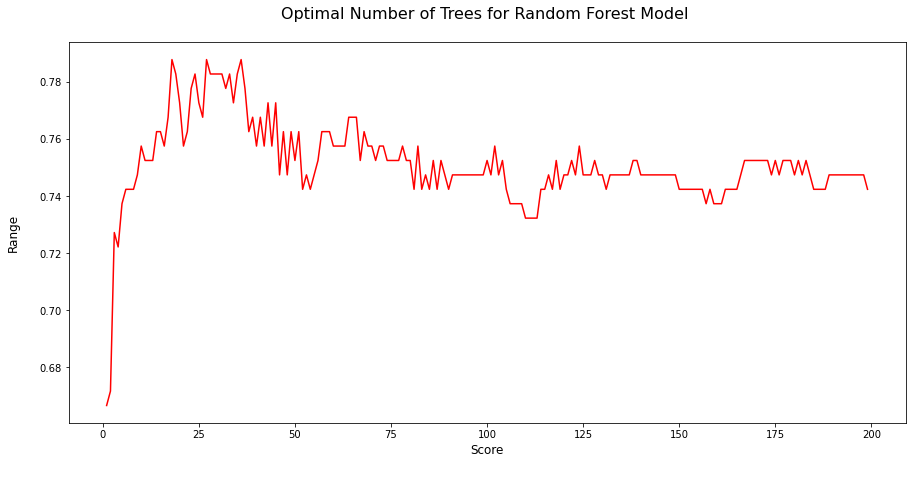

In [153]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,200),score_array, color = 'r')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontsize = "16")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

#### Randomized Search Cross Validation

In [154]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True})
Train Result:
Accuracy Score: 93.72%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.943478    0.931034  0.937229    0.937256      0.937310
recall       0.931330    0.943231  0.937229    0.937281      0.937229
f1-score     0.937365    0.937093  0.937229    0.937229      0.937230
support    233.000000  229.000000  0.937229  462.000000    462.000000
_______________________________________________
Confusion Matrix: 
 [[217  16]
 [ 13 216]]

Test Result:
Accuracy Score: 72.73%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.739583   0.715686  0.727273    0.727635      0.7277

Random search allowed us to narrow down the range for each hyperparameter. 

We can explicitly specify every combination of settings to try. 

We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define

#### Grid Search Cross Validation

In [155]:
pipe_rfc = Pipeline([('scl', StandardScaler()), ('rfc', RandomForestClassifier(random_state=0, n_jobs=-1) )])
param_grid_rfc =  [{'rfc__n_estimators': [100, 200,300,400], 'rfc__max_features':[0.05 , 0.1],
                    'rfc__max_depth': [None, 5], 'rfc__min_samples_split': [0.005, 0.01]}]

kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state= 0)
grid_rfc = GridSearchCV(pipe_rfc, param_grid= param_grid_rfc, cv=kfold, scoring='f1', verbose= 1, n_jobs=-1)

start = time()
grid_rfc = grid_rfc.fit(x_train, y_train)
end = time()

print("RFC grid search took %.3f seconds" %(end-start))
print('-------Best score----------')
print(grid_rfc.best_score_ * 100.0)
print('-------Best params----------')
print(grid_rfc.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
RFC grid search took 79.136 seconds
-------Best score----------
70.38844506088265
-------Best params----------
{'rfc__max_depth': None, 'rfc__max_features': 0.05, 'rfc__min_samples_split': 0.005, 'rfc__n_estimators': 400}


In [156]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=60, random_state=42)

In [157]:
fraud_check1['Taxable.Category'].unique()

['Good', 'Risky']
Categories (2, object): ['Risky' < 'Good']

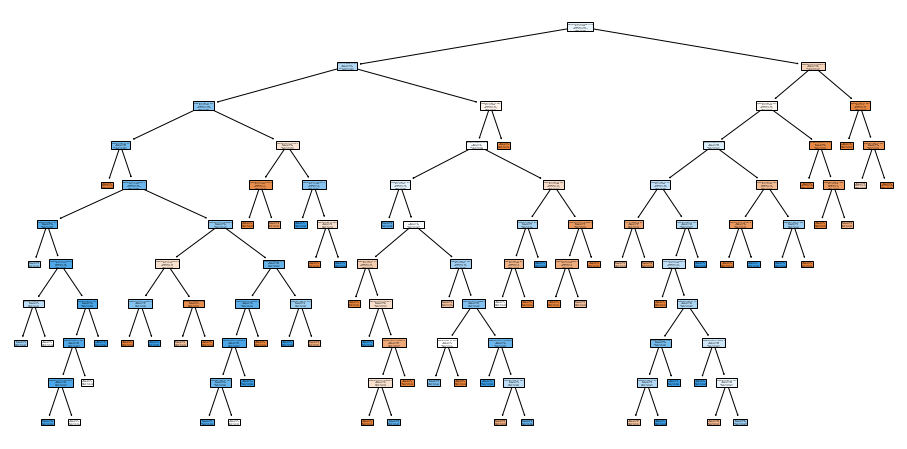

In [158]:
plt.figure(figsize=(16,8))
plot_tree(rf_best.estimators_[59], feature_names = fraud_check4.columns,class_names=fraud_check1['Taxable.Category'].unique(),filled=True)
plt.show()

#### Model Deployement

In [159]:
dump(rf_clf,open('fraud_check_intell.pkl','wb'))